In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xcep_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image


2025-12-14 14:44:10.413690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765723450.586905      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765723450.637243      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:

# ========== CONFIG ==========
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

data_dir = "/kaggle/input/cats-and-dogs"  # root folder containing train/val/test subfolders
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

batch_size = 512
target_size = (150, 150)  # for CNN and can be changed for TL models; Xception expects >=71
epochs = 15
num_classes = 2  # binary
class_mode = "binary"

In [4]:
# ========== DATA LOADERS ==========
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


train_flow = train_gen.flow_from_directory(train_dir,
                                           target_size=target_size,
                                           batch_size=batch_size,
                                           class_mode=class_mode,
                                           shuffle=True,
                                           seed=seed)

val_flow = val_gen.flow_from_directory(val_dir,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode=class_mode,
                                       shuffle=False,
                                       seed=seed)

test_flow = test_gen.flow_from_directory(test_dir,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode=class_mode,
                                        shuffle=False,
                                        seed=seed)

Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [5]:
# ========== UTIL: PLOT HISTORY ==========
def plot_history(hist, title_prefix):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # Accuracy
    plt.subplot(1,2,2)
    acc_key = 'accuracy' if 'accuracy' in hist.history else 'acc'
    plt.plot(hist.history[acc_key], label='train_acc')
    if 'val_'+acc_key in hist.history:
        plt.plot(hist.history['val_'+acc_key], label='val_acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ========== PART 1: SIMPLE CNN ==========
def build_simple_cnn(input_shape=(150,150,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:

print("Building simple CNN...")
cnn_model = build_simple_cnn((target_size[0], target_size[1], 3))
cnn_model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
]

history_cnn = cnn_model.fit(
    train_flow,
    epochs=epochs,
    validation_data=val_flow,
    callbacks=callbacks
)

Building simple CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765723493.501777      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765723493.502458      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1765723511.277908     115 service.cc:148] XLA service 0x7811280064b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765723511.278630     115 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765723511.278661     115 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765723511.643502     115 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-14 14:45:25.975216: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng18{k11=0} for conv (f32[32,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,3,150,150]{3,2,1,0}, f32[512,32,148,148]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id

40/40 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.5225 - loss: 0.8145 - val_accuracy: 0.6675 - val_loss: 0.6431
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.6371 - loss: 0.6444 - val_accuracy: 0.6888 - val_loss: 0.5824
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.6854 - loss: 0.5906 - val_accuracy: 0.7349 - val_loss: 0.5279
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.7072 - loss: 0.5550 - val_accuracy: 0.7458 - val_loss: 0.5260
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7171 - loss: 0.5564 - val_accuracy: 0.7671 - val_loss: 0.4932
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.7474 - loss: 0.5167 - val_accuracy: 0.7751 - val_loss: 0.4793
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.7544 - loss: 0.5025 - val_accuracy: 0.8024 - val_loss: 0.4404
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.7661 - loss: 0.4793 - val_accuracy: 0.7888 - val_loss: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8236 - loss: 0.3886
SIMPLE CNN - Test loss: 0.3525, Test accuracy: 0.8436


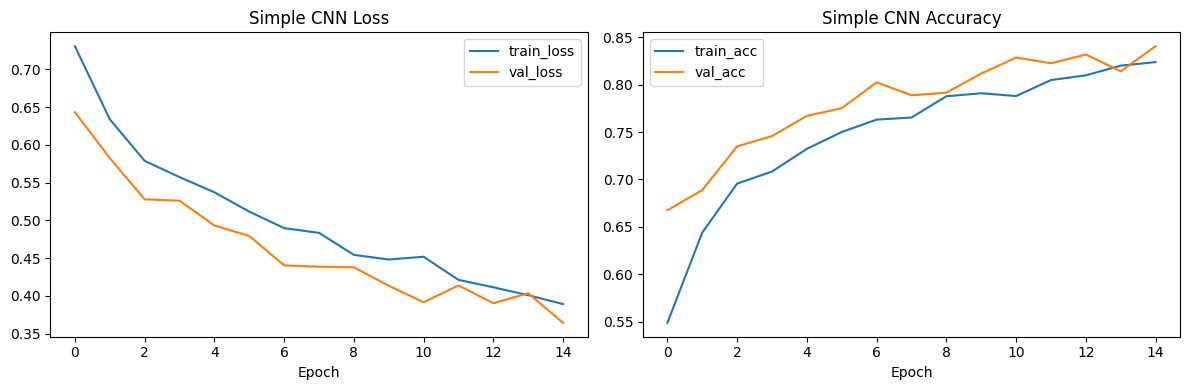

In [7]:
# Evaluate on test
loss_cnn, acc_cnn = cnn_model.evaluate(test_flow, verbose=1)
print(f"SIMPLE CNN - Test loss: {loss_cnn:.4f}, Test accuracy: {acc_cnn:.4f}")
plot_history(history_cnn, "Simple CNN")

Building VGG16 transfer model...
Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/15


2025-12-14 15:31:16.908769: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-12-14 15:31:17.169916: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.261255533s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

157/157 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.7330 - loss: 1.5115 - val_accuracy: 0.9707 - val_loss: 0.0979
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.9388 - loss: 0.2143 - val_accuracy: 0.9755 - val_loss: 0.0793
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9526 - loss: 0.1549 - val_accuracy: 0.9771 - val_loss: 0.0800
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9637 - loss: 0.1165 - val_accuracy: 0.9787 - val_loss: 0.0715
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9650 - loss: 0.1039 - val_accuracy: 0.9779 - val_loss: 0.0630
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9682 - loss: 0.0966 - val_accuracy: 0.9795 - val_loss: 0.0622
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.9751 - loss: 0.0779 - val_accuracy: 0.9803 - val_loss: 0.0592
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9756 - loss: 0.0707 - val_accuracy: 0.980

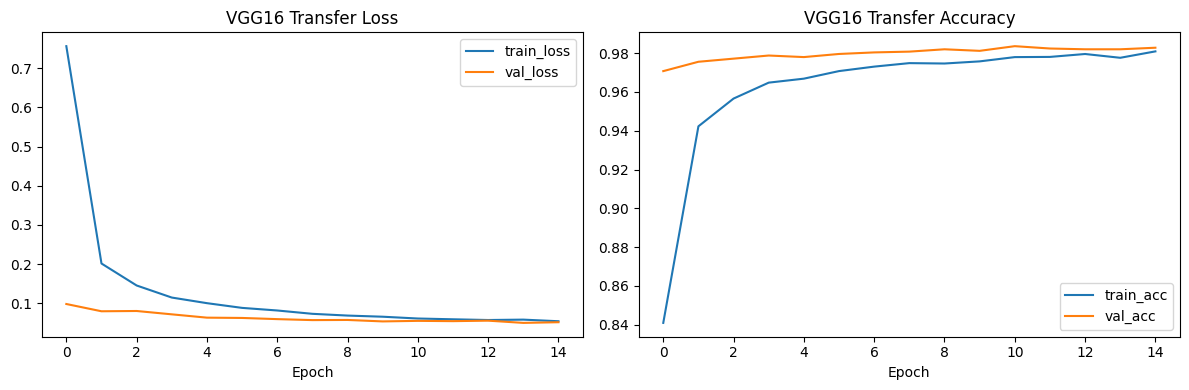

In [14]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'   # включить постепенное выделение памяти# 
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'      # можно включать при необходимости, но иногда вызывает проблемы
import tensorflow as tf

batch_size = 128
    
# ========== PART 2: TRANSFER LEARNING ==========
def build_tl_model(base_model, input_shape, preprocess_fn, train_base=False):
    inputs = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda img: img)(inputs)  # placeholder (we will preprocess via generator or later)
    base = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = train_base
    x = base(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# For TL we need data generators that apply model-specific preprocess_input
def make_preproc_flow(preprocess_fn, flow_from_dir, target_size, batch_size, shuffle=False):
    # wrap generator to apply preprocess_fn
    base_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    return base_gen.flow_from_directory(flow_from_dir.directory,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode=class_mode,
                                        shuffle=shuffle,
                                        seed=seed)

# VGG16
print("Building VGG16 transfer model...")
vgg_input_size = (224, 224)  # VGG16 typical input
train_flow_vgg = ImageDataGenerator(preprocessing_function=vgg_preprocess,
                                    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                    shear_range=0.1, zoom_range=0.1, horizontal_flip=True).flow_from_directory(
                                        train_dir, target_size=vgg_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=True, seed=seed)
val_flow_vgg = ImageDataGenerator(preprocessing_function=vgg_preprocess).flow_from_directory(
                                        val_dir, target_size=vgg_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=False, seed=seed)
test_flow_vgg = ImageDataGenerator(preprocessing_function=vgg_preprocess).flow_from_directory(
                                        test_dir, target_size=vgg_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=False, seed=seed)

vgg_base = VGG16
vgg_model = build_tl_model(vgg_base, input_shape=(vgg_input_size[0], vgg_input_size[1], 3), preprocess_fn=vgg_preprocess, train_base=False)
vgg_model.summary()

history_vgg = vgg_model.fit(train_flow_vgg, epochs=epochs, validation_data=val_flow_vgg, callbacks=callbacks)
loss_vgg, acc_vgg = vgg_model.evaluate(test_flow_vgg, verbose=1)
print(f"VGG16 TL - Test loss: {loss_vgg:.4f}, Test accuracy: {acc_vgg:.4f}")
plot_history(history_vgg, "VGG16 Transfer")

In [15]:
# Xception
print("Building Xception transfer model...")
xcep_input_size = (150, 150)  # Xception supports >=71, can use 150 or 299 depending on resources
train_flow_xcp = ImageDataGenerator(preprocessing_function=xcep_preprocess,
                                    rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                    shear_range=0.1, zoom_range=0.1, horizontal_flip=True).flow_from_directory(
                                        train_dir, target_size=xcep_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=True, seed=seed)
val_flow_xcp = ImageDataGenerator(preprocessing_function=xcep_preprocess).flow_from_directory(
                                        val_dir, target_size=xcep_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=False, seed=seed)
test_flow_xcp = ImageDataGenerator(preprocessing_function=xcep_preprocess).flow_from_directory(
                                        test_dir, target_size=xcep_input_size, batch_size=batch_size, class_mode=class_mode, shuffle=False, seed=seed)



Building Xception transfer model...
Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8827 - loss: 0.2628 - val_accuracy: 0.9643 - val_loss: 0.0871
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 156s 991ms/step - accuracy: 0.9523 - loss: 0.1161 - val_accuracy: 0.9667 - val_loss: 0.0801
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9585 - loss: 0.1057 - val_accuracy: 0.9663 - val_loss: 0.0785
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9598 - loss: 0.0999 - val_accuracy: 0.9651 - val_loss: 0.0789
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 156s 992ms/step - accuracy: 0.9654 - loss: 0.0906 - val_accuracy: 0.9667 - val_loss: 0.0764
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 977ms/step - accuracy: 0.9643 - loss: 0.0901 - val_accuracy: 0.9667 - val_loss: 0.0761
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 156s 991ms/step - accuracy: 0.9653 - loss: 0.0862 - val_accuracy: 0.9663 - val_loss: 0.0762
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9658 - loss: 0.086

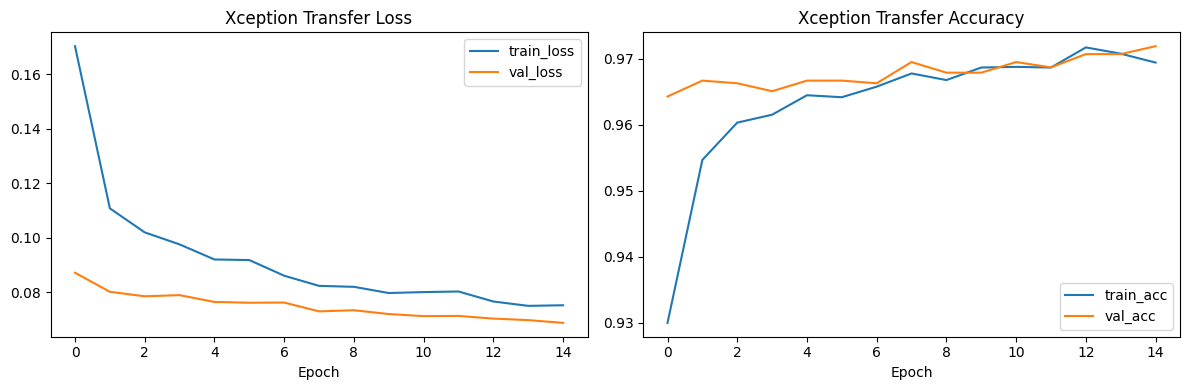

In [16]:
xcep_base = Xception
xcep_model = build_tl_model(xcep_base, input_shape=(xcep_input_size[0], xcep_input_size[1], 3), preprocess_fn=xcep_preprocess, train_base=False)
xcep_model.summary()

history_xcep = xcep_model.fit(train_flow_xcp, epochs=epochs, validation_data=val_flow_xcp, callbacks=callbacks)
loss_xcep, acc_xcep = xcep_model.evaluate(test_flow_xcp, verbose=1)
print(f"Xception TL - Test loss: {loss_xcep:.4f}, Test accuracy: {acc_xcep:.4f}")
plot_history(history_xcep, "Xception Transfer")

In [21]:
# ========== INFERENCE FUNCTION ==========
# Choose best model based on test accuracy
models_results = {
    'simple_cnn': (cnn_model, acc_cnn, target_size, lambda x: x),  # cnn uses rescale generator already
    'vgg': (vgg_model, acc_vgg, vgg_input_size, vgg_preprocess),
    'xception': (xcep_model, acc_xcep, xcep_input_size, xcep_preprocess)
}
best_key = max(models_results.keys(), key=lambda k: models_results[k][1])
best_model, best_acc, best_size, best_preproc = models_results[best_key]
print(f"Best model: {best_key} with test accuracy {best_acc:.4f}")

def predict_image(model, img_path, target_size, preprocess_fn, class_indices=None, threshold=0.5):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    # preprocess: if preprocess_fn is identity (lambda x: x) assume image values [0,1]
    if preprocess_fn is not None:
        x = preprocess_fn(x)
    # if preprocess_fn didn't scale to batch dimension, ensure batch
    x = np.expand_dims(x, axis=0)
    preds = model.predict(x)
    prob = float(preds[0][0])
    label = 1 if prob >= threshold else 0
    # map label to class name if available
    if class_indices is None:
        class_map = {v: k for k, v in train_flow.class_indices.items()}
    else:
        class_map = {v: k for k, v in class_indices.items()}
    return class_map.get(label, str(label)), prob


# wrapper: inference by best model
def inference_best(img_path):
    model, acc, size, preproc = best_model, best_acc, best_size, best_preproc
    # for simple cnn, our preprocessing expects inputs scaled to [0,1], but we used preprocess_fn=lambda x:x
    # ensure preprocessing: if preproc is identity, we do /255
    def _pre(x):
        if preproc == (lambda x: x):
            return x/255.0
        # some preprocess functions expect float images in 0-255; Keras ones handle that
        return preproc(x)
    label, prob = predict_image(model, img_path, target_size=size, preprocess_fn=_pre, class_indices=train_flow.class_indices)
    print(f"Inference by {best_key}: label={label}")
    return label, prob

Best model: vgg with test accuracy 0.9828


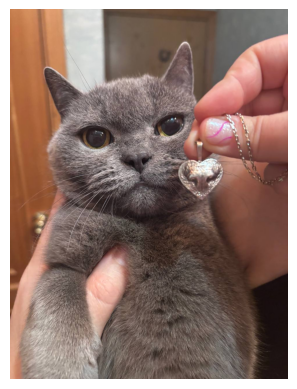

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_path = '/kaggle/input/markiz/2025-12-14 19.51.31.jpg'
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
inference_best(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Inference by vgg: label=cats


('cats', 4.292632915792183e-10)